## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

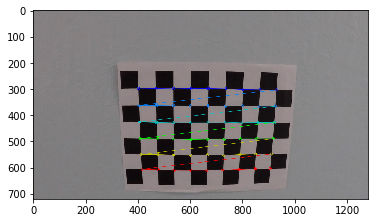

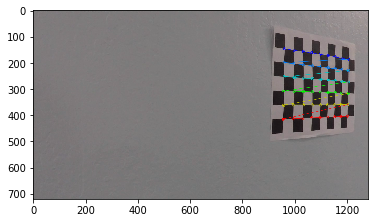

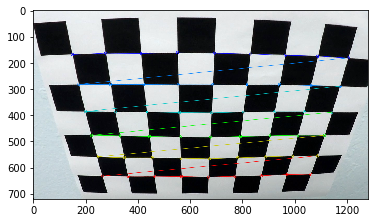

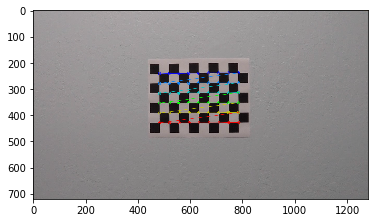

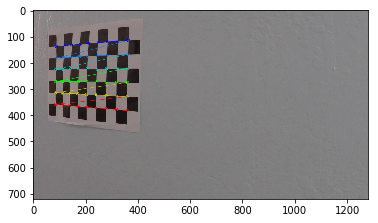

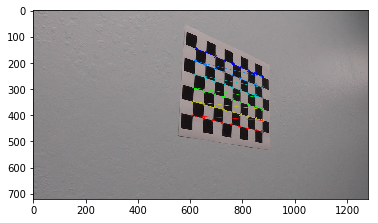

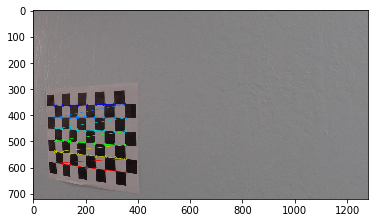

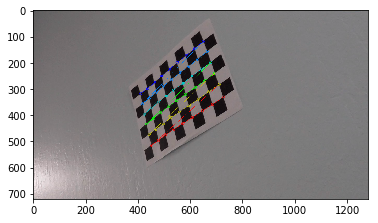

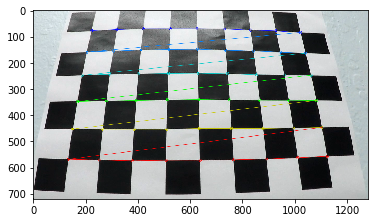

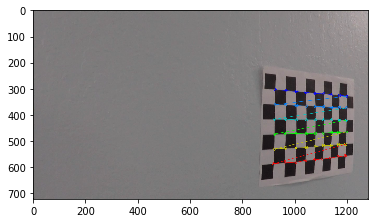

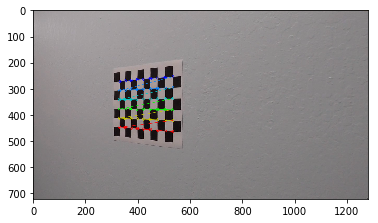

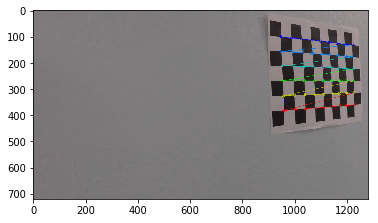

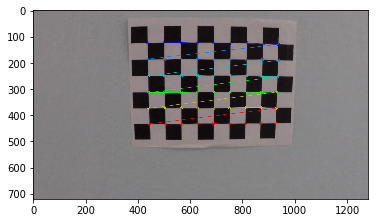

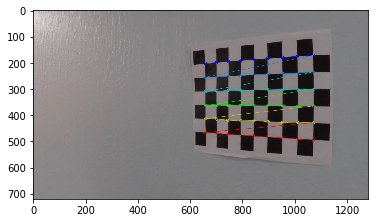

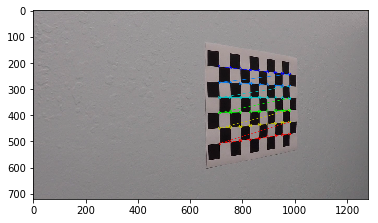

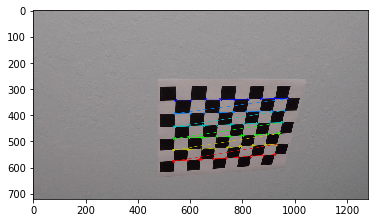

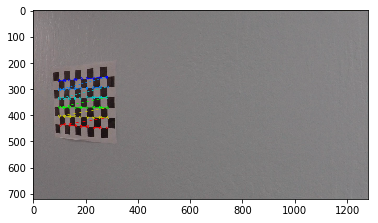

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        plt.figure()
        plt.imshow(img)

## Correcting distortion

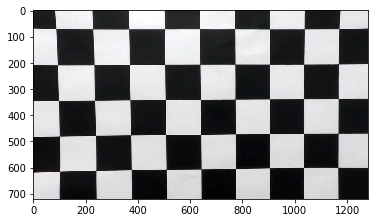

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)
plt.figure
undistorted_img = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistorted_img)

In [3]:
cv2.imwrite('./output_images/undistorted_chessboard.jpg', undistorted_img)

True

## doing processes

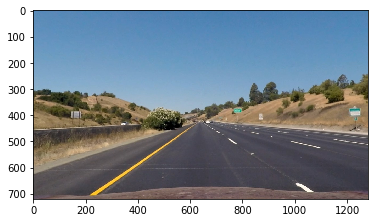

In [4]:
def read_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cal_undistort(img, objpoints, imgpoints)
    return img

img1 = read_image('./test_images/straight_lines1.jpg')
img2 = read_image('./test_images/straight_lines2.jpg')
img3 = read_image('./test_images/test1.jpg')
img4 = read_image('./test_images/test2.jpg')
img5 = read_image('./test_images/test3.jpg')
img6 = read_image('./test_images/test4.jpg')
img7 = read_image('./test_images/test5.jpg')
img8 = read_image('./test_images/test6.jpg')

plt.imshow(img1)

## Perspective transform and get IOU

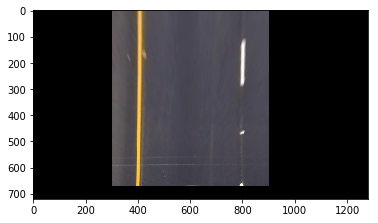

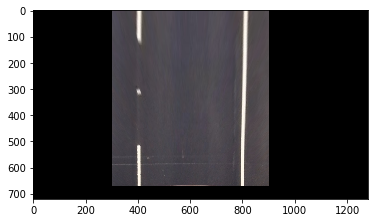

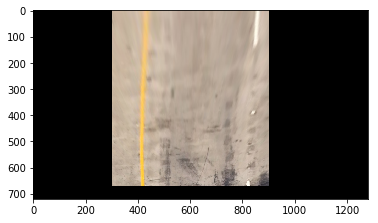

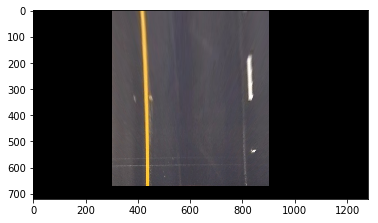

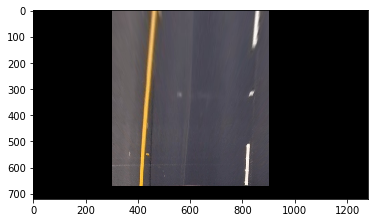

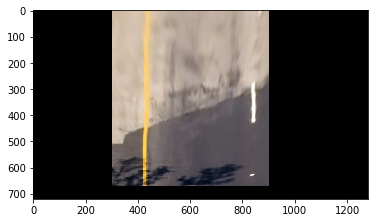

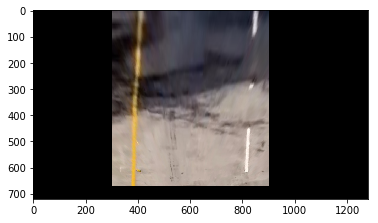

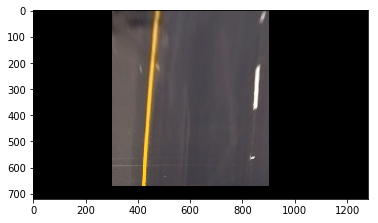

In [172]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def unwarp(img):
    imshape = img.shape
    src = np.float32([[300, 655], [550, 480], [730, 480], [1000, 650]])
    dst = np.float32([[400, 650], [400, 0], [800, 0], [800, 650]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (imshape[1],imshape[0]))
    
    vertices = np.array([[(300, 670),
                              (300, 0), 
                              (900, 0), 
                              (900, 670)]])
    warped = region_of_interest(warped, vertices)
    return warped
    
img1_unwarped = unwarp(img1)
img2_unwarped = unwarp(img2)
img3_unwarped = unwarp(img3)
img4_unwarped = unwarp(img4)
img5_unwarped = unwarp(img5)
img6_unwarped = unwarp(img6)
img7_unwarped = unwarp(img7)
img8_unwarped = unwarp(img8)

plt.imshow(img1_unwarped)
plt.figure()
plt.imshow(img2_unwarped)
plt.figure()
plt.imshow(img3_unwarped)
plt.figure()
plt.imshow(img4_unwarped)
plt.figure()
plt.imshow(img5_unwarped)
plt.figure()
plt.imshow(img6_unwarped)
plt.figure()
plt.imshow(img7_unwarped)
plt.figure()
plt.imshow(img8_unwarped)


In [173]:
plt.imsave('./output_images/test_images_output/unwarped_straight_lines1.png', img1_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_straight_lines2.png', img2_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test1.png', img3_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test2.png', img4_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test3.png', img5_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test4.png', img6_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test5.png', img7_unwarped)
plt.imsave('./output_images/test_images_output/unwarped_test6.png', img8_unwarped)

## Get combined binary image

In [174]:
def my_threshold(img, th_min, th_max):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1) 
    abs_sobelx = np.absolute(sobelx) 
    abs_sobely = np.absolute(sobely) 
    abs_sobelxy = cv2.addWeighted(abs_sobelx, 0.7, abs_sobely, 0.3, 0);
    
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    thresh_min = th_min
    thresh_max = th_max
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary
    
def getCombined(img):
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    img_s = HLS[:,:,2]
    
    s_threshold = my_threshold(img_s, 130, 255)
    
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
    white = cv2.inRange(HSV, (0, 0, 200), (255, 20, 255))
    white_2 = cv2.inRange(HLS, (0, 200, 0), (255, 255, 60))
    white_3 = cv2.inRange(img, (200,200,200), (255,255,255))
    
    combined = yellow | white | white_2 | white_3
    
    combined_binary = np.zeros_like(s_threshold)
    combined_binary[(combined >= 20) & (combined <= 255)] = 1
    
    return cv2.bitwise_or(s_threshold, combined_binary)  

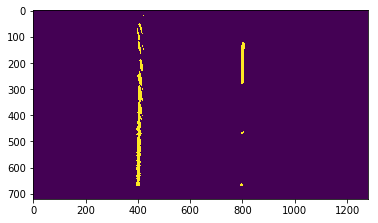

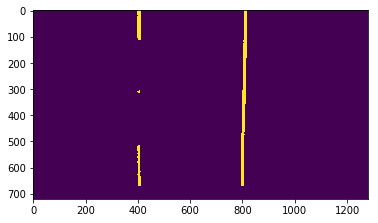

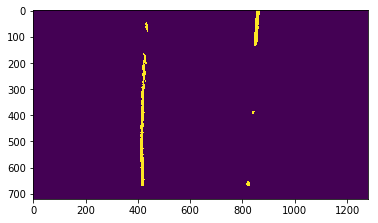

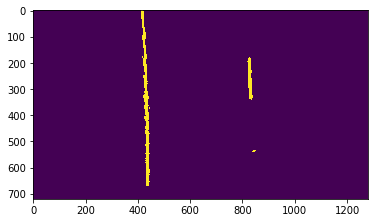

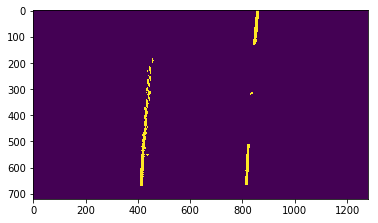

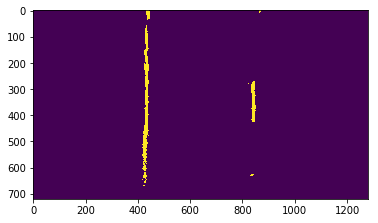

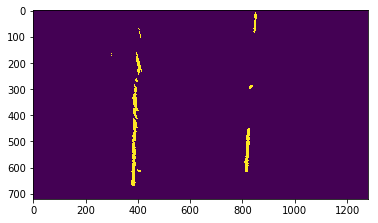

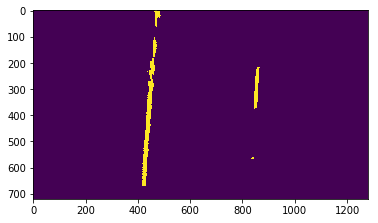

In [175]:
img1_combined = getCombined(img1_unwarped)
img2_combined = getCombined(img2_unwarped)
img3_combined = getCombined(img3_unwarped)
img4_combined = getCombined(img4_unwarped)
img5_combined = getCombined(img5_unwarped)
img6_combined = getCombined(img6_unwarped)
img7_combined = getCombined(img7_unwarped)
img8_combined = getCombined(img8_unwarped)

plt.figure()
plt.imshow(img1_combined)
plt.figure()
plt.imshow(img2_combined)
plt.figure()
plt.imshow(img3_combined)
plt.figure()
plt.imshow(img4_combined)
plt.figure()
plt.imshow(img5_combined)
plt.figure()
plt.imshow(img6_combined)
plt.figure()
plt.imshow(img7_combined)
plt.figure()
plt.imshow(img8_combined)

In [176]:
plt.imsave('./output_images/test_images_output/combined_threshold_straight_lines1.png', img1_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_straight_lines2.png', img2_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test1.png', img3_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test2.png', img4_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test3.png', img5_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test4.png', img6_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test5.png', img7_combined)
plt.imsave('./output_images/test_images_output/combined_threshold_test6.png', img8_combined)

## Find lines with windows

(720, 0)

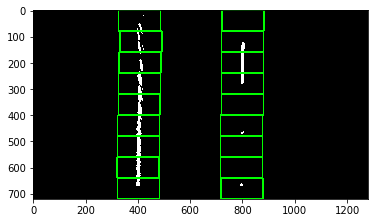

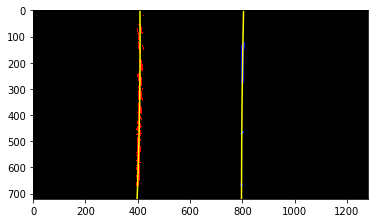

In [183]:
def find_lines_with_window(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    output = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # set window-num
    nwindows = 9
    # set height
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 80
    minpix = 40
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(output,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(output,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    plt.imshow(output)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) > 10:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 10:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # measure curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fit, right_fit, left_fitx, right_fitx, out_img, ploty, left_curverad, right_curverad

#    return out_img
left_fit, right_fit, left_fitx, right_fitx, out_img, ploty, left_curverad, right_curverad = find_lines_with_window(img1_combined)
plt.figure()
plt.imshow(out_img)
plt.imsave('./output_images/test_images_output/find_lines_with_window.png', out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Find lines without windows

(720, 0)

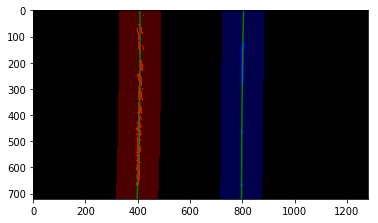

In [184]:
def find_lines_without_window(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) > 10:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 10:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    output = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(output)

    # Color in left and right line pixels
    output[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    output[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    my_transposed = np.transpose(np.vstack([left_fitx-margin, ploty]))

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # measure curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255, 0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 0, 255))
    output = cv2.addWeighted(output, 1, window_img, 0.3, 0)
    
    return output, left_fit, right_fit, left_fitx, right_fitx, ploty

out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = find_lines_without_window(left_fit, right_fit, img1_combined)
plt.imshow(out_img)
plt.imsave('./output_images/test_images_output/find_lines_without_window.png', out_img)

plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [185]:
#Function for drawing line areas and information text
def draw_info(img, warped_img, left_fitx, right_fitx, ploty, dst, src, left_from_center, average_curverad):
    #Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_img.shape[1], warped_img.shape[0])) 
    # Combine the result with the original image
    final_output = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(final_output, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(result, 'Radius of Curvature = ' + str(round(average_curverad)) + 'm',(50,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    #TODO : need to Change
    cv2.putText(result, 'Vehicle is ' + str(round(left_from_center,2)) + 'm left of center',(50,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    return result

## Test on video

In [186]:
import imageio
imageio.plugins.ffmpeg.download()

In [187]:
from moviepy.editor import VideoFileClip

def process_video(image):
    src = np.float32([[300, 655], [550, 480], [730, 480], [1000, 650]])
    dst = np.float32([[400, 650], [400, 0], [800, 0], [800, 650]])
    
    left_detected = False
    left_recent_xfitted = []
    left_bestx = None
    left_best_fit = None
    left_current_fit = [np.array([False])]
    left_radious_of_curvature = 0

    right_detected = False
    right_recent_xfitted = []
    right_bestx = None
    right_best_fit = None
    right_current_fit = [np.array([False])]
    right_radious_of_curvature = 0
    
    image = cal_undistort(image, objpoints, imgpoints)
    
    unwarped = unwarp(image)
    combined = getCombined(unwarped)
    
    left_curverad = 0
    right_curverad = 0
    left_from_center = 0
    
    if left_detected == False or right_detected == False:
        left_fit, right_fit, left_fitx, right_fitx, output_img , ploty, left_curverad, right_curverad = find_lines_with_window(combined)
        
        #measure distance from center
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        x_eval = int(np.average([left_fitx, right_fitx]))
        left_from_center = round((640 - x_eval) * xm_per_pix, 3)
        
        left_detected = True
        right_detected = True
        
        if len(left_recent_xfitted) == 0 and len(right_recent_xfitted) == 0:
            left_recent_xfitted.append(left_fitx)
            right_recent_xfitted.append(right_fitx)
            left_current_fit.append(left_fit)
            right_current_fit.append(right_fit)
        left_bestx = left_fitx
        right_bestx = right_fitx
        left_best_fit = left_fit
        right_best_fit = right_fit
        left_radius_of_curvature = left_curverad
        right_radius_of_curvature = right_curverad
    else :
        output_img, left_fit, right_fit, left_fitx, right_fitx, ploty, left_curverad, right_curverad = find_lines_without_window( left_best_fit, right_best_fit, combined)
        
        #measure distance from center
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        x_eval = int(np.average([left_fit, right_fit]))
        left_from_center = round((640 - x_eval) * xm_per_pix, 3)
        
    if len(left_recent_xfitted) == 7:
        del left_current_fit[0]
        del right_current_fit[0]
        del left_recent_xfitted[0]
        del right_recent_xfitted[0]
        
    if left_curverad < 400:
        left_detected = False
        left_recent_xfitted.append(left_bestx)
        left_current_fit.append(left_best_fit)
    # if curve is detected correctly, save the data in object.
    else:
        left_recent_xfitted.append(left_fitx)
        left_current_fit.append(left_fit)
        left_radius_of_curvature = left_curverad
        
    temp = np.zeros_like(left_fitx)
    for i in range(len(left_recent_xfitted)):
        temp = temp + left_recent_xfitted[i]
    left_bestx = temp / len(left_recent_xfitted)            
    temp = np.zeros_like(left_fit)
    for i in range(len(left_current_fit)):
        temp = temp + left_current_fit[i]
    left_best_fit = temp / len(left_current_fit)
        
    # same as left line.
    if right_curverad < 400:
        right_detected = False
        right_recent_xfitted.append(right_bestx)
        right_current_fit.append(right_best_fit)
    else:
        right_recent_xfitted.append(right_fitx)
        right_current_fit.append(right_fit)
        right_radius_of_curvature = right_curverad
        
    temp = np.zeros_like(right_fitx)
    for i in range(len(right_recent_xfitted)):
        temp = temp + right_recent_xfitted[i]
    right_bestx = temp / len(right_recent_xfitted)
    temp = np.zeros_like(right_fit)
    for i in range(len(right_current_fit)):
        temp = temp + right_current_fit[i]
    right_best_fit = temp / len(right_current_fit)
    
    # calculate average curvation between left side and right side.
    aver_curve = (left_radius_of_curvature + right_radius_of_curvature) / 2     
    result = draw_info(image, combined, left_bestx, right_bestx, ploty, dst, src, left_from_center, aver_curve)
    # This frame is BGR, so transform RGB image.
    result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    return result

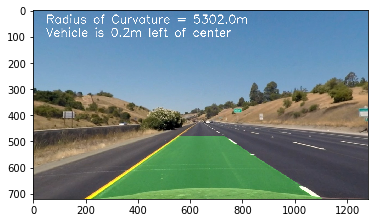

In [190]:
img_tested = process_video(img1)
plt.imshow(img_tested)
plt.imsave('./output_images/test_images_output/final_output.png', img_tested)

[MoviePy] >>>> Building video ./output_images/project_output.mp4
[MoviePy] Writing video ./output_images/project_output.mp4



100%|█████████▉| 1260/1261 [31:43<00:01,  1.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_output.mp4 

CPU times: user 33min 53s, sys: 7.26 s, total: 34min
Wall time: 31min 46s


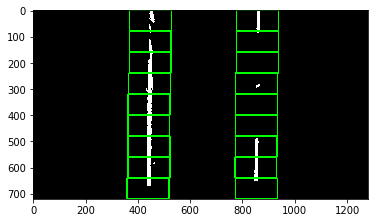

In [192]:
final_output = './output_images/project_output.mp4'
my_clip = VideoFileClip("./project_video.mp4")
final_clip = my_clip.fl_image(process_video) #NOTE: this function expects color images!!
%time final_clip.write_videofile(final_output, audio=False)